   0  0.1
0  1    0
1  2    0
2  3    0
3  4    0
4  5    0


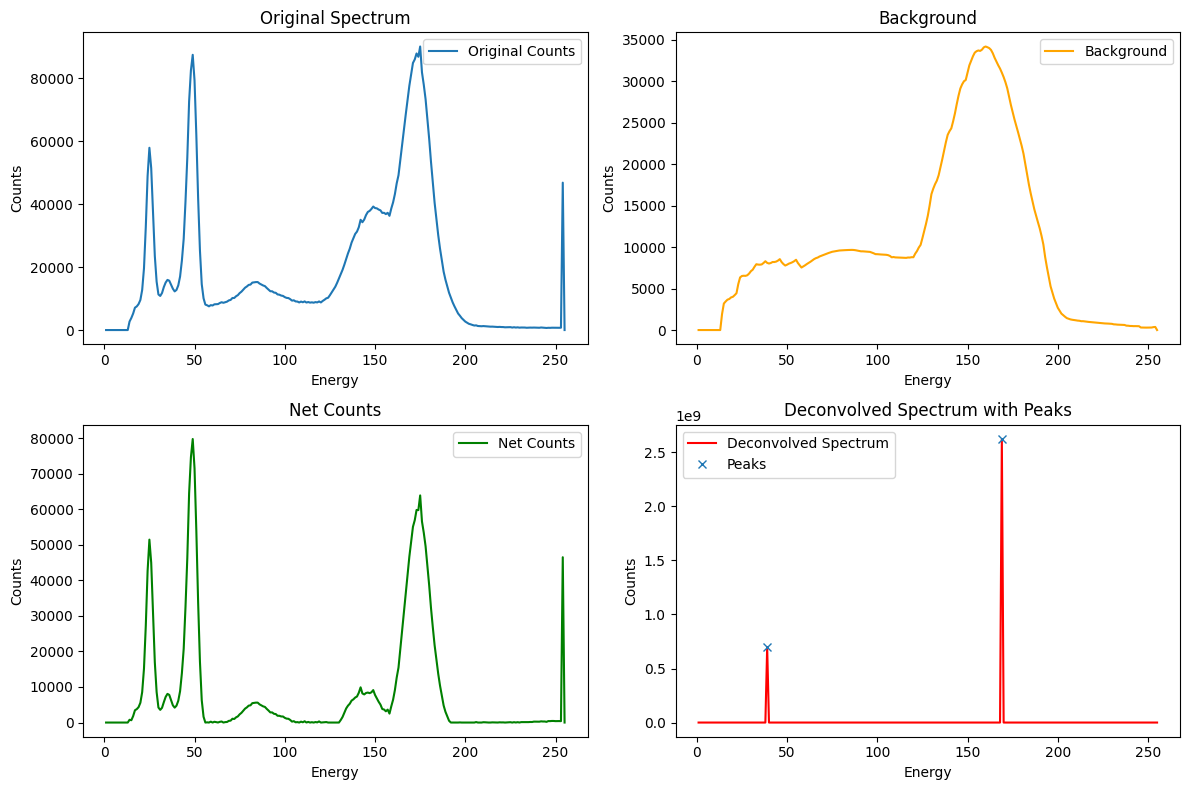

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

def read_spectrum(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)
    print(data.head())  # Print the first few rows to check the column names
    energy = data.iloc[:, 0]  # Assuming energy values are in the first column
    counts = data.iloc[:, 1]  # Assuming counts are in the second column
    return energy, counts

def snip_background(counts, width):
    # Implementing SNIP algorithm for background elimination
    background = counts.copy()
    for i in range(width):
        for j in range(i, len(counts) - i):
            background[j] = min(background[j], (background[j - i] + background[j + i]) / 2)
    return background

def gaussian_response_matrix(energy, FWHM_params):
    a, b, c = FWHM_params
    response_matrix = np.zeros((len(energy), len(energy)))

    for i in range(len(energy)):
        E = energy[i]
        FWHM = np.sqrt(a * E**2 + b * E + c)
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        response_matrix[:, i] = np.exp(-(energy - E)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

    return response_matrix

def gold_deconvolution(spectrum, response_matrix, iterations=100, boosting_coefficient=1.5):
    f = np.ones_like(spectrum)
    H_T = response_matrix.T
    y_0 = H_T @ spectrum

    for _ in range(iterations):
        f = f * (y_0 / (H_T @ (response_matrix @ f)))
        f = f ** boosting_coefficient

    return f

def identify_peaks(energy, spectrum, height=None, distance=None):
    peaks, properties = find_peaks(spectrum, height=height, distance=distance)
    return peaks, properties

def process_spectrum(file_path, snip_width=10, smoothing_sigma=1.0, peak_height_ratio=0.05, peak_distance=10, FWHM_params=(1, 1, 1)):
    energy, counts = read_spectrum(file_path)

    # Background elimination
    background = snip_background(counts, snip_width)
    net_counts = counts - background

    # Smoothing the spectrum
    smoothed_counts = gaussian_filter1d(net_counts, sigma=smoothing_sigma)

    # Constructing the response matrix
    response_matrix = gaussian_response_matrix(energy, FWHM_params)

    # Applying Gold deconvolution algorithm
    deconvolved_spectrum = gold_deconvolution(smoothed_counts, response_matrix)

    # Identify peaks in the deconvolved spectrum
    peaks, properties = identify_peaks(energy, deconvolved_spectrum, height=peak_height_ratio*np.max(deconvolved_spectrum), distance=peak_distance)

    return energy, counts, background, net_counts, smoothed_counts, deconvolved_spectrum, peaks, properties

def plot_spectrum(energy, counts, background, net_counts, smoothed_counts, deconvolved_spectrum, peaks):
    plt.figure(figsize=(12, 8))

    # Original Counts
    plt.subplot(2, 2, 1)
    plt.plot(energy, counts, label='Original Counts')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Original Spectrum')
    plt.legend()

    # Background
    plt.subplot(2, 2, 2)
    plt.plot(energy, background, label='Background', color='orange')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Background')
    plt.legend()

    # Net Counts
    plt.subplot(2, 2, 3)
    plt.plot(energy, net_counts, label='Net Counts', color='green')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Net Counts')
    plt.legend()

    # Deconvolved Spectrum with Peaks
    plt.subplot(2, 2, 4)
    plt.plot(energy, deconvolved_spectrum, label='Deconvolved Spectrum', color='red')
    plt.plot(energy[peaks], deconvolved_spectrum[peaks], 'x', label='Peaks')
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Deconvolved Spectrum with Peaks')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
file_path = '15.5.csv'  # Path to your CSV file

# Process the spectrum
FWHM_params = (1, 1, 1)  # Replace with actual FWHM calibration parameters
energy, counts, background, net_counts, smoothed_counts, deconvolved_spectrum, peaks, properties = process_spectrum(
    file_path, snip_width=10, smoothing_sigma=1.0, peak_height_ratio=0.05, peak_distance=10, FWHM_params=FWHM_params)

# Save the results to a new CSV file
result_df = pd.DataFrame({
    'Energy': energy,
    'Original Counts': counts,
    'Background': background,
    'Net Counts': net_counts,
    'Smoothed Spectrum': smoothed_counts,
    'Deconvolved Spectrum': deconvolved_spectrum,
    'Peak': [1 if i in peaks else 0 for i in range(len(energy))]
})
result_df.to_csv('processed_spectrum.csv', index=False)

# Plot the results
plot_spectrum(energy, counts, background, net_counts, smoothed_counts, deconvolved_spectrum, peaks)
